In [68]:
############## LOAD PACKAGES ###########
conda install conda-forge::r-ape

library("fmesher")
library(MatrixModels)
library(Matrix)
library(INLA)
library(inlabru)
library("jpeg")
library("png")

library(sf)
library(terra)
library(dplyr)
library(spdep)
library(raster)
library(exactextractr)

library(ggplot2)
library(viridis)
library(sn)
library("ape")

In [69]:
######################### LOAD THE OUTLINE OF MEXICO AND ADMIN BOUNDARIES #############
options(repr.plot.width=10, repr.plot.height=10)
mexico = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/ecort08gw_DESECON1_DISS.gpkg", quiet = TRUE) %>% st_union() %>% st_transform(crs = 6933) # Provided by CONAFOR and converted to a projected CRS so we can work in units of meters

In [75]:
# ########################## READ THE MEXICAN NFI DATA ###################################
plot_WGS84 <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/Daso_A_Cgl_C3_V7_24052022_1.gpkg", quiet = TRUE)

loc.plot.WGS84 <- st_coordinates(plot_WGS84)  ### get the plot locations in WGS84
plot = plot_WGS84 %>% st_transform("epsg:6933") ### convert them to a projected CRS
agbd.plot = plot$AGB_C3 ### get the AGBD estimate at each plot location
loc.plot = st_coordinates(plot) ### save the plot location xy coordinates in projected CRS
n.plot = nrow(loc.plot) ### check the number of plots

####################### LOAD THE GLAD FOREST HEIGHTS MAP #######################
hei.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/GLAD_FH_mexico_UINT16_C_6399.tif")### Read GLAD FOREST HEIGHT raster, already in projected CRS
hei.plot = exactextractr::exact_extract(hei.rast, st_buffer(plot,56.42), 'mean')
hei.plot_LARGE = exactextractr::exact_extract(hei.rast, st_buffer(plot,86.42), 'mean')
hei.plot_EXTRACT = extract(hei.rast, st_buffer(plot,86.42), 'mean')

####################### LOAD THE CCI BIOMASS MAP #######################
cci.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/cci_mexico_6933.tif") ### Read CCI raster, already in projected CRS
cci.plot = exactextractr::exact_extract(cci.rast, st_buffer(plot,56.42), 'mean')
cci.plot_LARGE = exactextractr::exact_extract(cci.rast, st_buffer(plot,86.42), 'mean')
cci.plot_EXTRACT = extract(cci.rast, st_buffer(plot,86.42), 'mean')

Cannot preload entire working area of 9385516650 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 9386023392 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 742422165 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 742509466 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


In [84]:
cor(cci.plot,cci.plot_LARGE)
cor(cci.plot,(as.numeric(cci.plot_EXTRACT[,2])))

[1] 0.9983759

[1] 0.9969788

In [93]:
DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/NFI_CCI_GEDIheights.csv") #Read the saved data
colnames(DATA)

# following https://stats.oarc.ucla.edu/r/faq/how-can-i-calculate-morans-i-in-r/
houseDF.dists <- as.matrix(dist(cbind(DATA$X, DATA$X.1)))
houseDF.dists.inv <- 1/houseDF.dists
houseDF.dists.inv[is.infinite(houseDF.dists.inv)] <- 0
diag(houseDF.dists.inv) <- 0

Moran.I(DATA$agbd.plot, houseDF.dists.inv)

[1] "X"         "X.1"       "cci.plot"  "hei.plot"  "agbd.plot"

$observed
[1] 0.09541067

$expected
[1] -0.0001013993

$sd
[1] 0.0003076518

$p.value
[1] 0

In [41]:
DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/NFI_CCI_GEDIheights.csv") #Read the saved data
cci.plot <- DATA$cci.plot
hei.plot <- DATA$hei.plot
loc.plot <- data.frame(matrix(ncol = 2, nrow = length(hei.plot))) # Just create empty list to populated with saved NFI xy locations
n.plot = nrow(loc.plot)
loc.plot[,1] <- DATA$X
loc.plot[,2] <- DATA$X.1
agbd.plot <- (DATA$agbd.plot) 
DATA$agbd.plot <- sqrt(DATA$agbd.plot)


Call:
lm(formula = (agbd.plot) ~ (cci.plot) + (hei.plot), na.action = na.omit)

Residuals:
     Min       1Q   Median       3Q      Max 
-148.585  -14.275   -5.777   13.706  232.825 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.2946624  0.4724327  17.557   <2e-16 ***
cci.plot    -0.0004286  0.0153290  -0.028    0.978    
hei.plot     4.5408228  0.0701397  64.740   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 31.64 on 9860 degrees of freedom
Multiple R-squared:  0.4916,	Adjusted R-squared:  0.4915 
F-statistic:  4767 on 2 and 9860 DF,  p-value: < 2.2e-16


Time used:
    Pre = 0.296, Running = 0.837, Post = 0.119, Total = 1.25 
Fixed effects:
             mean    sd 0.025quant 0.5quant 0.975quant  mode kld
(Intercept) 2.465 0.038      2.390    2.465      2.539 2.465   0
cci.plot    0.005 0.001      0.002    0.005      0.007 0.005   0
hei.plot    0.368 0.006      0.357    0.368      0.379 0.368   0

Model hyperparameters:
                                         mean    sd 0.025quant 0.5quant
Precision for the Gaussian observations 0.156 0.002      0.151    0.156
                                        0.975quant  mode
Precision for the Gaussian observations       0.16 0.155

Deviance Information Criterion (DIC) ...............: 46352.05
Deviance Information Criterion (DIC, saturated) ....: 9869.02
Effective number of parameters .....................: 3.99

Watanabe-Akaike information criterion (WAIC) ...: 46353.19
Effective number of parameters .................: 5.12

Marginal log-Likelihood:  -23209.08 
CPO, PIT is computed 
Posterior 

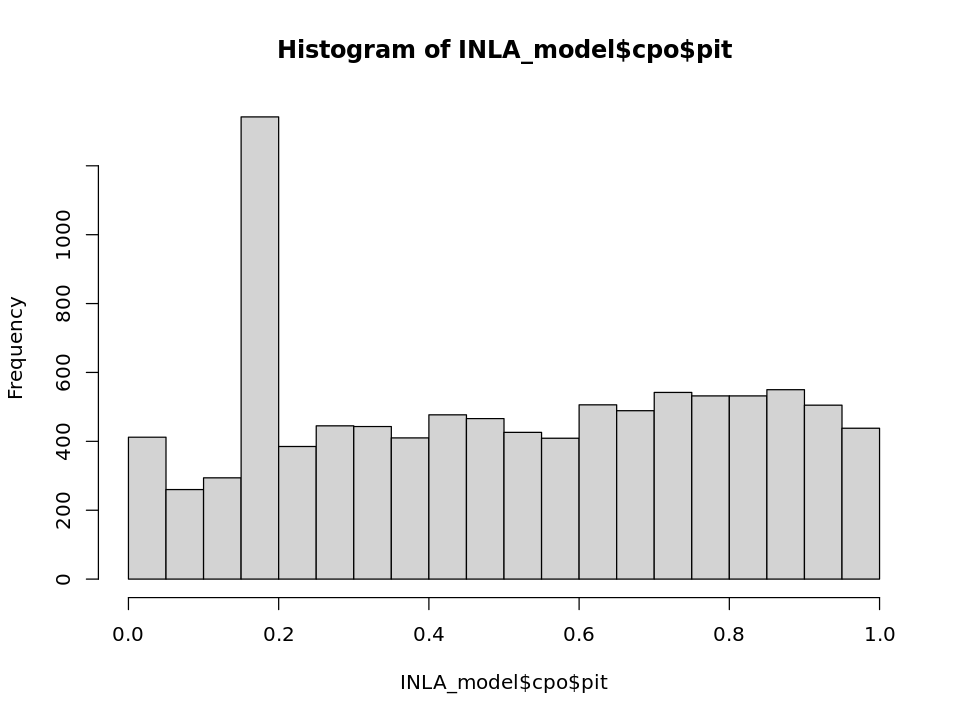

In [55]:
###################### SETTING UP THE MODEL SO THAT INLA CAN RUN IT ##################
LM_model <- (lm((agbd.plot)~(cci.plot)+(hei.plot), na.action=na.omit))
summary(LM_model)

formula = (agbd.plot)~(cci.plot)+(hei.plot)
INLA_model <- inla(formula, data=DATA, family="gaussian",control.compute=list(config = T, dic = T, waic = T, cpo=TRUE)) #option cpo is a leave-one-out cross validation
summary(INLA_model)
hist(INLA_model$cpo$pit, breaks = 20)

In [43]:
########################## LET'S CHECK HOW OUR MODEL PERFORMS ON OUR "TESTING" NFI LOCATIONS ############

plot_WGS84_T <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/TESTING.gpkg",quiet=TRUE)

plot_T = plot_WGS84_T %>% st_transform("epsg:6933") ### convert testing plot locations to a projected CRS
agbd.plot_T = sqrt(plot_T$AGB_C3) ### get the AGBD estimate at each plot location and square root it
loc.plot_T = st_coordinates(plot_T) ### save the plot location xy coordinates in projected CRS

hei.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/GLAD_FH_mexico_UINT16_C_6399.tif")### Read GLAD FOREST HEIGHT raster, already in projected CRS
hei.pred = exactextractr::exact_extract(hei.rast, st_buffer(plot_T,56.42), 'mean') # Extract pixel values under plot using weighted-mean of area of each pixel
# hei.pred = terra::extract(hei.rast, st_buffer(plot_T,56.42)) ### Extract pixel-level height values at each NFI plot location + 56.42 buffer
# hei.pred = aggregate(x = hei.pred$GLAD_FH_mexico_UINT16_C_6399, by = list(hei.pred$ID), FUN = mean, na.rm=TRUE)[,2] ### Average pixel values per plot

cci.rast=rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/cci_mexico_6933.tif") ### Read CCI raster, already in projected CRS
cci.pred = exactextractr::exact_extract(cci.rast, st_buffer(plot_T,56.42), 'mean') # Extract pixel values under plot using weighted-mean of area of each pixel
# cci.pred = terra::extract(cci.rast, st_buffer(plot_T,56.42)) ### Extract CCI pixel-level AGBD values at each NFI plot location + 56.42 buffer
# cci.pred = aggregate(x = cci.pred$cci_mexico, by = list(cci.pred$ID), FUN = mean, na.rm=TRUE)[,2] ### Average pixel values per plot

Cannot preload entire working area of 8849227632 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 700041580 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


[1] 0.4096111

[1] 34.92944

[1] -6.457501

Warning message:
“Removed 662 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


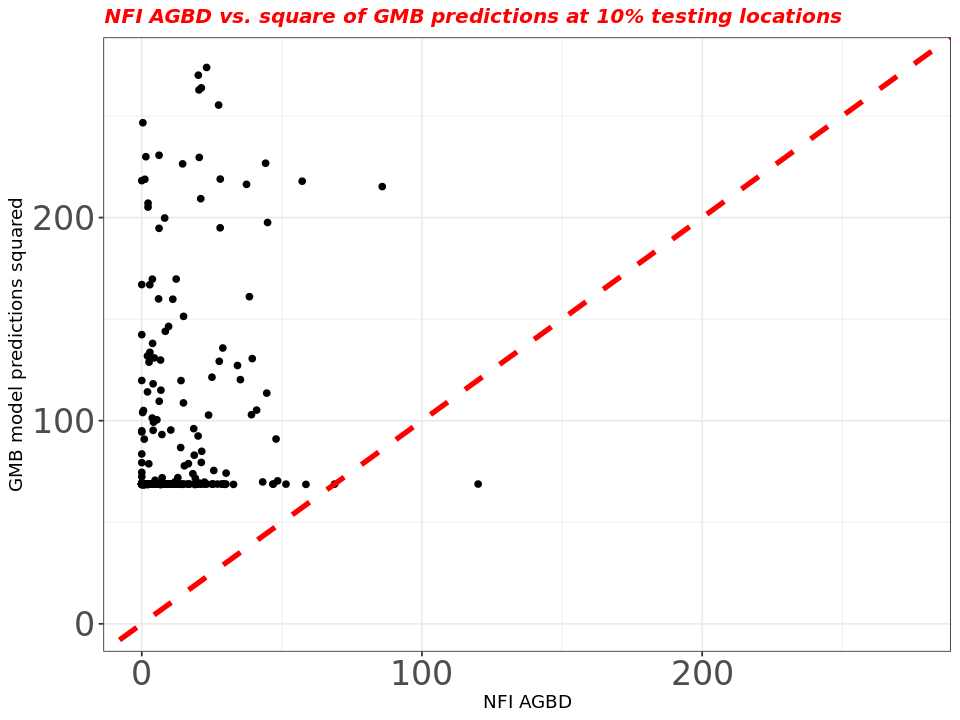

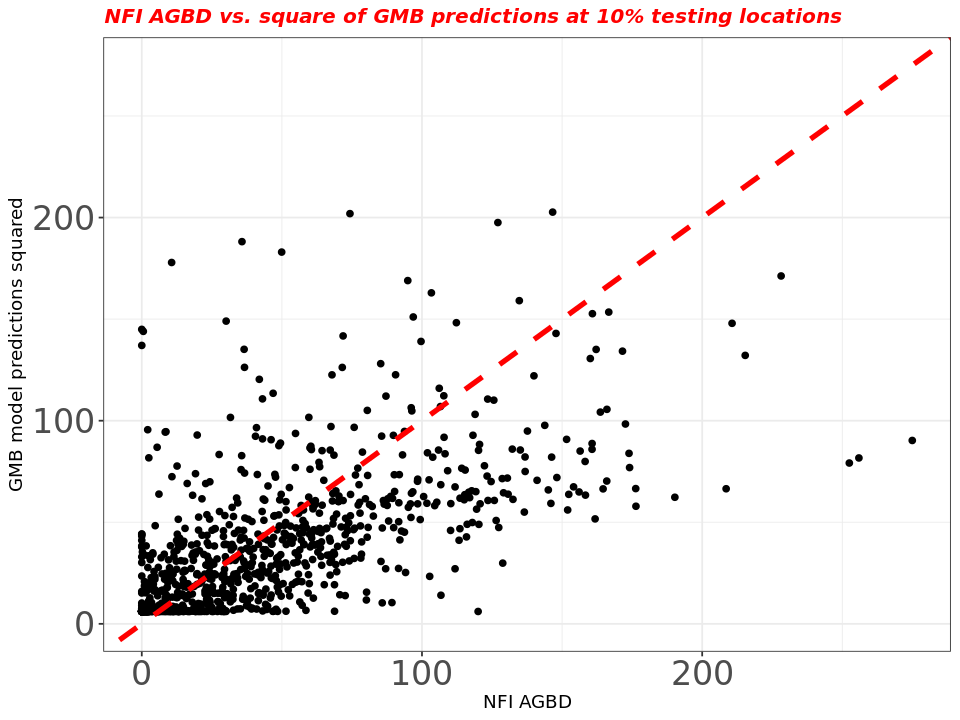

In [67]:
# newobs = data.frame(X=NA,X.1=NA,hei.plot=hei.pred,cci.plot=cci.pred,agbd.plot=NA)
# chpred = rbind(DATA,newobs)
# respred <- inla(formula, family="gaussian", control.predictor=list(compute=TRUE), data=chpred)
# respred$summary.fixed
# predictions <- tail(respred$summary.fitted.values, nrow(newobs))


# chpred$idx <- 1:nrow(chpred)
# eformula <- (agbd.plot)~(cci.plot)+(hei.plot) + f(idx, model="iid", hyper = list(prec = list(param=c(1, 0.01))))
# respred <- inla(eformula, data = chpred, control.predictor = list(compute=TRUE), control.family=list(initial=12,fixed=TRUE))
# respred$summary.fixed
# predictions <- tail(respred$summary.fitted.values, nrow(newobs))
# predictions$NFI <- agbd.plot_T^2
# predictions$PRED <- predictions$mean^2

LM_PRED <- predict(LM_model, newdata=newobs, interval = "confidence", se=TRUE)
predictions$LM_PRED <- as.numeric(LM_PRED$fit[,1])^2

######################## HEURISTICS: R2 AND RMSE ###################
R2_backtrans = 1 - (sum((predictions$mean^2 - agbd.plot_T^2)^2)/sum((agbd.plot_T^2 - mean(agbd.plot_T^2))^2))
R2_backtrans
RMSE = sqrt(mean((predictions$mean^2 - agbd.plot_T^2)^2))
RMSE
mean(predictions$mean^2) - mean(agbd.plot_T^2)

ggplot(data = predictions, aes(x = NFI,y = LM_PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,275) + ylim(0,275) + xlab("NFI AGBD") + ylab("GMB model predictions squared") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))
ggplot(data = predictions, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,275) + ylim(0,275) + xlab("NFI AGBD") + ylab("GMB model predictions squared") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 678 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 609 rows containing missing values or values outside the scale range
(`geom_point()`).”


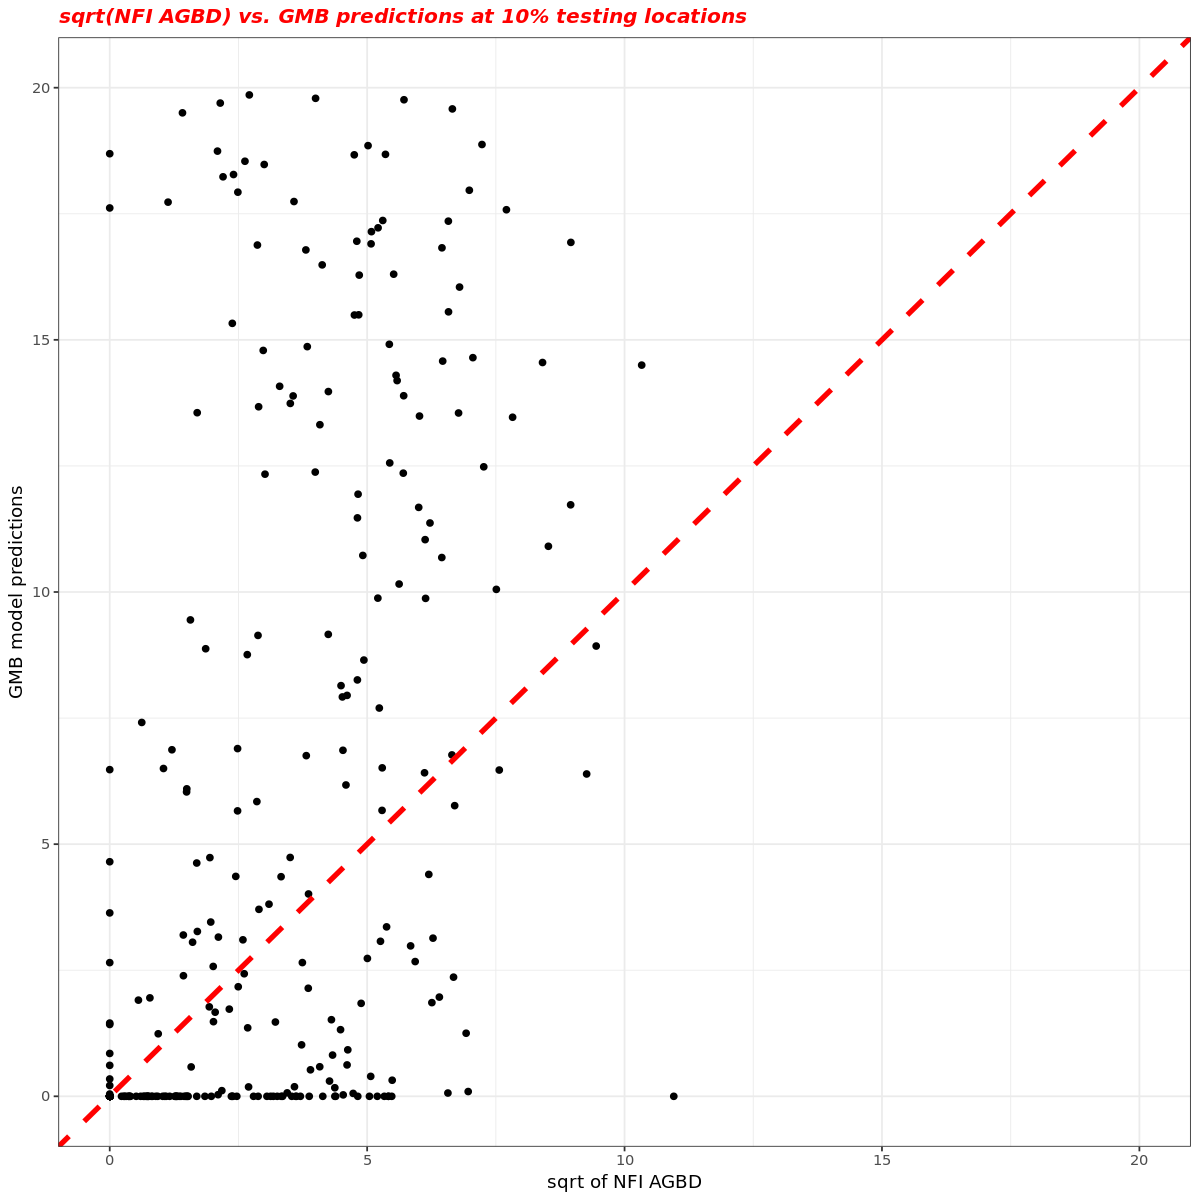

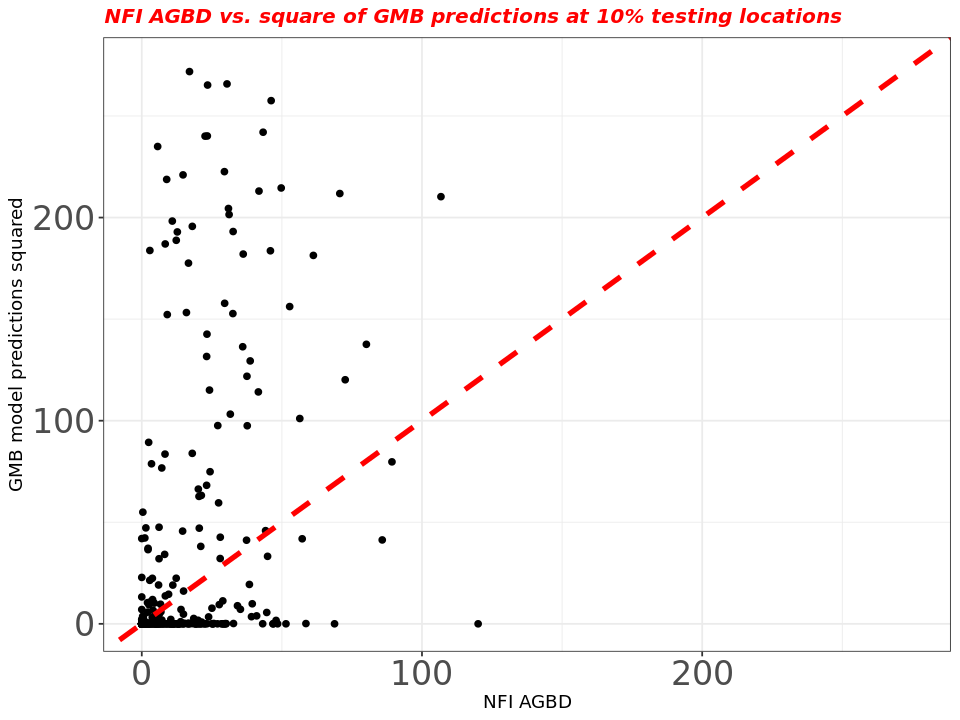

In [16]:
# Now, we have to draw "posterior samples" from our model results because it is numerically difficult to compute what our model parameters are at any given location. 
# By drawing samples from the model outputs, we are able to describe the expected model outcomes and use them in predicting AGBD at our desired testing plot locations. 

samples = inla.posterior.sample(n = 250, result = INLA_model)  ### Draw 2000 samples
 

# Our prediction function, supplied with both the model parameters and the covariates. 
pred_fun = function(...){
  drop(cci.pred*cci.plot + 
    hei.pred*hei.plot)
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples)
pred.sd = apply(pred.samples, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=agbd.plot_T, PRED.SD=pred.sd, RES=agbd.plot_T-pred.mu))
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point() + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,20) + ylim(0,20) + xlab("sqrt of NFI AGBD") + ylab("GMB model predictions") + ggtitle("sqrt(NFI AGBD) vs. GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"))

################## COMPUTE A HEURISTIC FOR ACCURACY, LIKE AN R2 VALUE #############
 # Computing a value like an R^2 for our testing locations will give us an idea of prediction error at unobserved locations

# Let's also square the model expectations because we applied a sqrt transformation at the start
pred.mu = Matrix::rowMeans(pred.samples^2)
pred.sd = apply(pred.samples^2, 1, sd)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=agbd.plot_T^2, PRED.SD=pred.sd, RES=agbd.plot_T^2-pred.mu))
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,275) + ylim(0,275) + xlab("NFI AGBD") + ylab("GMB model predictions squared") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))
        
####################### And here are some maps to see what the predictions look like at the plot locations ##########
# options(repr.plot.width=6, repr.plot.height=6)
# ggplot() + coord_sf(crs = 6933) + 
#            geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = agbd.plot_T^2),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
#            scale_color_viridis(limits = c(0, 150)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("NFI-estimated AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) +
#            geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites

# ggplot() + coord_sf(crs = 6933) + 
#            geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
#            scale_color_viridis(limits = c(0, 150)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) + 
#            geom_sf(data = Deforestation,col="red",fill=NA,lwd=1)# add our fake deforestation sites